# Homework 3 - Genetics
DATA 901 - Austin Smith

In [162]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import ElasticNetCV
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('ggplot')

In [2]:
genes = pd.read_csv('HW3_genes.csv', header = None)
genes = genes.T

## Section 1:
In this part we use gene expression data from 40 tissue samples. The first twenty samples are from patients with cancer and the other twenty are from patients without. In this data, there are 1,000 columns of gene expressions. Below is the first five rows of the data to get an understanding for what it looks like. The Purpose of this section is to compare machine learning algorithms and their ability to determine whehter or not a patient has cancer from the gene expressions.

In [95]:
genes.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,Clusters
0,-0.961933,-0.292526,0.258788,-1.152132,0.195783,0.030124,0.085418,1.116610,-1.218857,1.267369,...,-0.116171,-1.470146,-0.379272,-1.465006,1.075148,-1.226125,-3.056328,1.450658,0.717977,1
1,0.441803,-1.139267,-0.972845,-2.213168,0.593306,-0.691014,-1.113054,1.341700,-1.277279,-0.918349,...,-0.162392,-0.633375,-0.895521,2.034465,3.003267,-0.501702,0.449889,1.310348,0.763482,1
2,-0.975005,0.195837,0.588486,-0.861525,0.282992,-0.403426,-0.677969,0.103278,-0.558925,-1.253500,...,-0.235912,1.446660,-1.127459,0.440849,-0.123441,-0.717430,1.880362,0.383837,0.313576,1
3,1.417504,-1.281121,-0.800258,0.630925,0.247147,-0.729859,-0.562929,0.390963,-1.344493,-1.067114,...,1.597294,0.737478,-0.631248,-0.530442,-1.036740,-0.169113,-0.742841,-0.408860,-0.326473,1
4,0.818815,-0.251439,-1.820398,0.951772,1.978668,-0.364099,0.938194,-1.927491,1.159115,-0.240638,...,-0.086946,-0.122342,1.418029,1.075337,-1.270604,0.599530,2.238346,-0.471111,-0.158700,1


To get an idea of what the data looks like, I created the following 3-dimensional scatter plot. It is clear that there are two distinct groups in the data. 

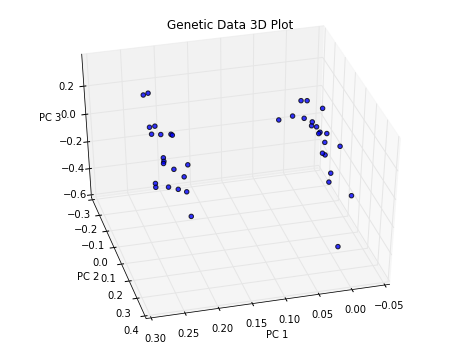

In [7]:
#PCA 
pca = PCA(n_components=3,random_state=50)
pca.fit(genes.T)
pca = pd.DataFrame({'PC1':pca.components_[0],
'PC2':pca.components_[1],
'PC3':pca.components_[2]})

#plot

#Colors For 3d Cluster Plot
colorsdict = {
0: 'r',
1: 'g',
}

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca['PC1'],pca['PC2'],pca['PC3'],
alpha = .8,
c = 'b')

ax.set_title('Genetic Data 3D Plot')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

ax.view_init(azim= 75, elev=40)

### Kmeans Clustering
The first algorithm I will use is Kmeans clustering. This is a technique which is used to find groups of similar points in the data, called clusters. In this example, we know we are looking for two groups, cancerous and not cancerous. The K-Means algortihm is an iterative process where it initializes K (in this case 2) centroids and goes through to detirmine which points are closest to the centroids. The points are grouped by proximity to the centroid. This process is an example of unsupervised learning, since we typically do not know which groups these points belong to prior to clustering. In this case, since we know that the first twenty rows contain healthy patients and the last twenty rows contain patients with cancer, we can determine the accuracy of Kmeans.

The 3-dimensional plot below shows the outcome of KMeans clustering on our data. The algorithm returned 100% accuracy of clustering the groups. Red points are part of the diseased group and green points are part of the healthy group.

In [8]:
#Cluster on All
clust = KMeans(n_clusters = 2, random_state = 50)
clust.fit(genes)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=50, tol=0.0001, verbose=0)

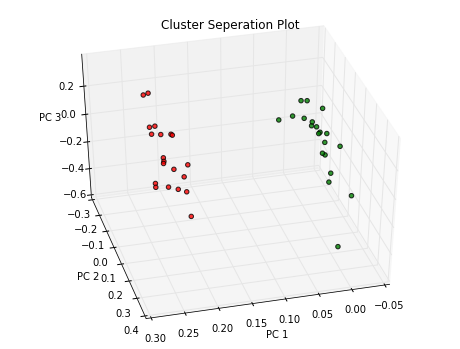

In [9]:
#PCA 
pca = PCA(n_components=3,random_state=50)
pca.fit(genes.T)
pca = pd.DataFrame({'PC1':pca.components_[0],
'PC2':pca.components_[1],
'PC3':pca.components_[2],
'Clust':clust.labels_})

#plot

#Colors For 3d Cluster Plot
colorsdict = {
0: 'r',
1: 'g',
}

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca['PC1'],pca['PC2'],pca['PC3'],
alpha = .8,
c = [colorsdict[x] for x in pca['Clust']],)

ax.set_title('Cluster Seperation Plot')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

ax.view_init(azim= 75, elev=40)

In [11]:
genes['Clusters'] = clust.labels_

### Non-Linear Models
Next, we look at  the following non-linear models:
- Decision Tree
- Random Forest
- Boosted Trees

In the execution of these models, I will use two forms of cross validation.
- <b>Train Test Split:</b> This is a simple method of validating a model, it involves leaving out a present amount of the data. The model is trained on some data and then prediction accuracy is tested on the data that was left out. In this case 1/4 of the data is left out.<br> 
- <b>Leave One Out:</b> Runs a train test split using one row as a the test and the rest of the data as training. It iterates through using each row once and generates in this case, 40 seperate accuracy scores. The mean of all of these scores is the cross validated score.<br>

In [78]:
#Initialize Cross Validation and Train/Test Split

#Set X and y
X, y = genes.iloc[:,:-1], genes['Clusters']

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=50)

#Initialize Cross-Val
loo = LeaveOneOut()

### Decision Tree
Decision trees for classification or regression, except, instead of being linear in nature, they form a tree structrure. It does this by breaking the dataset into smaller and smaller partitions and develops a tree. The independent variables can be categorical or continuous. A simple example would be a child deciding if they want to play as shown below.
<img src = "https://media.licdn.com/mpr/mpr/shrinknp_800_800/AAEAAQAAAAAAAAZ5AAAAJGU4MGQyYzM2LTY2ZjgtNGYzYi04NWEyLTVkZGU3ODUxNjljNw.png"/>

The algorithim starts at the top and works its way down using  greedy search through all options. Decision trees can easily overfit data if they are allowed to run deep enough and split every piece of data.

Below is a confusion matrix for the results of a decision tree run on the data to determine whether or not a patient has cancer, as we can see, it misclassifies almost a quarter of all patients.


In [1]:
#Decision Tree - Train Test Split
clf = DecisionTreeClassifier(random_state=50)
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)
conf = pd.DataFrame(confusion_matrix(y_test, clf_pred))
conf.columns = ['Predicted Cancerous', 'Predicted Healthy']
conf.index = ['Actual Cancerous', 'Actual Healthy']
conf

NameError: name 'DecisionTreeClassifier' is not defined

In [80]:
#Decision Tree - Cross Validated
print('Decision Tree Cross Validated Mean Squared Error: {}'
.format(np.abs(cross_val_score(clf, X, y, cv = loo, scoring = 'neg_mean_squared_error').mean())))
print('Decision Tree Cross Validated Accuracy: {}'
.format(np.abs(cross_val_score(clf, X, y, cv = loo, scoring = 'accuracy').mean())))

Decision Tree Cross Validated Mean Squared Error: 0.225
Decision Tree Cross Validated Accuracy: 0.775


### Random Forest
A single decision tree has shortcomings, mainly the concept of overfitting the data and not predicting out of sample data well. The random forest combats this by fitting a large number of decision trees with randomly selected variables and observations. It is known as an ensemble method since it is aggregating a large amount of trees. The random component of it is in its selection of variables and observations. In each tree, the algorithm randomly selects variables, with replacement. This means that if a variable is selected, it is not excluded for future selection. Thus about 2/3 of the data is selected each time. Next, a random subset of variables is selected for each tree. In a random forest, the accuracy of each tree is calculated by checking the misclassifcation of the observations which were not randomly selected, aka the remaining 1/3. This is known as the out of bag error rate.

Below is the resulting confusion matrix of a random forest used on this data in order to classify patients. As you can see in this case, it achieved 100% accuracy.

In [147]:
#Random Forest - Train Test Split
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=50)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
conf = pd.DataFrame(confusion_matrix(y_test, rf_pred))
conf.columns = ['Predicted Cancerous', 'Predicted Healthy']
conf.index = ['Actual Cancerous', 'Actual Healthy']
conf

,Predicted Cancerous,Predicted Healthy
Actual Cancerous,5,0
Actual Healthy,0,5


In [148]:
#Random Fores - Cross Validated
print('Random Forest Cross Validated Mean Squared Error: {}'
.format(np.abs(cross_val_score(rf, X, y, cv = loo, scoring = 'neg_mean_squared_error').mean())))
print('Random Forest Cross Validated Accuracy: {}'
.format(np.abs(cross_val_score(rf, X, y, cv = loo, scoring = 'accuracy').mean())))

Random Forest Cross Validated Mean Squared Error: 0.0
Random Forest Cross Validated Accuracy: 1.0


### Adaptive Boosting
In general terms, boosting is an ensemble method similar to random forest, however, it grows many simple decision trees (weak learners) and each successive tree is created for the prediction errors of the previous tree. The adaptive boosting algorithm used below uses the following progression:
1. Start with a small tree, which isn't a very strong predictor.
2. Create a second tree to predict the residuals from the first.
3. Find the residual values of first two trees combined and fit third tree to predict those values.
4. Any observations which are incorrect are weighted more heavily in the next iteration. 
5. Classifiers which are accurate predictors recieve more weight and ones which are not accurate predictors recieve less weight in the final model.
6. The output of the model is a weighted average of all the decision trees.

As shown below in this example, this method produced 100% accuracy.

In [137]:
#ADA Boost - Train Test Split
ada = AdaBoostClassifier(random_state=50)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)
conf = pd.DataFrame(confusion_matrix(y_test, rf_pred))
conf.columns = ['Predicted Cancerous', 'Predicted Healthy']
conf.index = ['Actual Cancerous', 'Actual Healthy']
conf

,Predicted Cancerous,Predicted Healthy
Actual Cancerous,5,0
Actual Healthy,0,5


In [84]:
#Ada Boost - Cross Validated
print('AdaBoost Cross Validated Mean Squared Error: {}'
.format(np.abs(cross_val_score(rf, X, y, cv = loo, scoring = 'neg_mean_squared_error').mean())))
print('AdaBoost Cross Validated Accuracy: {}'
.format(np.abs(cross_val_score(rf, X, y, cv = loo, scoring = 'accuracy').mean())))

AdaBoost Cross Validated Mean Squared Error: 0.0
AdaBoost Cross Validated Accuracy: 1.0


### Linear Models
Next, we look at  the following linear models:
- Logistic Regression
- Ridge Regression
- Lasso
- ElasticNet

In the execution of these models, I will use the same two forms of cross validation as used above.

### Logistic Regression

A logistic regression a for of an ordinary least squares linear regression where. Except, the dependent variable is a binary categorical variable, either 0 or 1. The function assigns weights to each variable and produces an output of a decimal between zero and one. Rounding it to the nearest digit yields the classification. <br>
The following table shows a confusion matrix for the logistic regression run with all variables available on the test data after training the model. Additionally, I used Leave One Out cross validation to compute the Mean Squared Error and Accuracy. 

In [107]:
#logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
conf = pd.DataFrame(confusion_matrix(y_test, lr_pred))
conf.columns = ['Predicted Cancerous', 'Predicted Healthy']
conf.index = ['Actual Cancerous', 'Actual Healthy']
conf

,Predicted Cancerous,Predicted Healthy
Actual Cancerous,5,0
Actual Healthy,5,0


In [108]:
#Logistic Regression - Cross Validated
print('Logistic Regression Cross Validated Mean Squared Error: {}'
.format(np.abs(cross_val_score(lr, X, y, cv = loo, scoring = 'neg_mean_squared_error').mean())))
print('Logistic Regression Cross Validated Accuracy: {}'
.format(np.abs(cross_val_score(lr, X, y, cv = loo, scoring = 'accuracy').mean())))

Logistic Regression Cross Validated Mean Squared Error: 0.4
Logistic Regression Cross Validated Accuracy: 0.6


### Ridge Regression
This is a different type of a linear model that applies a penalty to shrink the coefficients toward zero. In reducing the beta vector there is a variance-bias-tradeoff depicted below:
<img src = "http://www.kdnuggets.com/wp-content/uploads/bias-and-variance.jpg"/>



<b>Variance:</b> is error from sensitivity to small fluctuations in the training set. High variance can cause overfitting, the modeling the random noise in the training data, rather than the intended outputs.

<b>Bias:</b> is error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting).

The penalty of the betas is the l2 penalty (sum of betas squared). A tuning parameter lambda is used to tune the model in order to penalize the Betas as little as possible.
<img src="http://businessforecastblog.com/wp-content/uploads/2014/05/ridgeregressionOF.png"/>

<b>Bottom Line:</b>

It is mainly used to prevent overfitting. Since it includes all the features, it is not very useful in case of exorbitantly high number of features, say in millions, as it will pose computational challenges.

It generally works well even in presence of highly correlated features as it will include all of them in the model but the coefficients will be distributed among them depending on the correlation.

In the case of this example, we see that ridge regression was able to get 100% accuracy in both our train/test split and our cross validation, as depicted below.

In [111]:
#Ridge
ridge = RidgeClassifier(alpha = 0.1)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
conf = pd.DataFrame(confusion_matrix(y_test, ridge_pred))
conf.columns = ['Predicted Cancerous', 'Predicted Healthy']
conf.index = ['Actual Cancerous', 'Actual Healthy']
conf

,Predicted Cancerous,Predicted Healthy
Actual Cancerous,5,0
Actual Healthy,0,5


In [112]:
#Ridge Regression - Cross Validated
print('Ridge Regression Cross Validated Mean Squared Error: {}'
.format(np.abs(cross_val_score(ridge, X, y, cv = loo, scoring = 'neg_mean_squared_error').mean())))
print('Ridge Regression Cross Validated Accuracy: {}'
.format(np.abs(cross_val_score(ridge, X, y, cv = loo, scoring = 'accuracy').mean())))

Ridge Regression Cross Validated Mean Squared Error: 0.0
Ridge Regression Cross Validated Accuracy: 1.0


### Lasso
Lasso performs the same function as the Ridge regression, however the penalty is different, in this one, it is the l1 penalty, which is the (Sum of Absolute Value of Betas). This forces some of the independent variables to zero. Aka eliminates them from the model. 

A limitation of this method is that if p>n aka there are more variables than samples, it can only use an equal or lower amount of variables. It will not allow there to be more samples than variables. This is a major disadvantage in fields like genomics because the number of genes that can be regressed is limited by the number of samples. However, in this case, we hope it will narrow down to specific fatores in the genes that predict cancer in patients.

Objective = RSS + α * (sum of absolute value of coefficients)

<img src="https://www.analyticsvidhya.com/wp-content/uploads/2016/01/eq8-1.png"/>

<b>Bottom Line:</b>

Since it provides sparse solutions, it is generally the model of choice for modelling cases where the number of features are in millions or more. In such a case, getting a sparse solution is of great computational advantage as the features with zero coefficients can be ignored.

Its not hard to see why the stepwise selection techniques become \very cumbersome to implement in high dimensionality cases. Thus, lasso provides a significant advantage.

It arbitrarily selects any one feature among the highly correlated ones and reduced the coefficients of the rest to zero. Also, the chosen variable changes randomly with change in model parameters. This generally doesn’t work that well as compared to ridge regression.

This disadvantage of lasso can be observed in the example we discussed above. In highly correlated data, we see that even small values of alpha give significant sparsity (i.e. high number coefficients as zero). 

In the case of this example, it predicts with 100% accuracy.

In [126]:
# Lasso 
lasso = LassoCV(alphas=[0.1], cv = None)
lasso.fit(X_train,y_train)
lasso_pred = lasso.predict(X_test)
conf = pd.DataFrame(confusion_matrix(y_test, lasso_pred.round()))
conf.columns = ['Predicted Cancerous', 'Predicted Healthy']
conf.index = ['Actual Cancerous', 'Actual Healthy']
conf

,Predicted Cancerous,Predicted Healthy
Actual Cancerous,5,0
Actual Healthy,0,5


In [90]:
#Lasso - Cross Validated
lasso = LassoCV(alphas=[0.1], cv = loo)
lasso.fit(X,y)
print('Lasso Cross Validated Mean Squared Error: {}'
.format(lasso.mse_path_.mean()))

Lasso Cross Validated Mean Squared Error: 0.033162830147279374


Below I have listed the Lasso coefficients that have not been zeroed. The algorithm kept 19 variables as the ones it found important to classify patients with cancer.

In [125]:
lasso_imp = pd.DataFrame(lasso.coef_).sort_values(by=0)[:19]
lasso_imp.columns = ['Lasso Variables Used']
lasso_imp

,Lasso Variables Used
501,-0.068024
592,-0.050167
598,-0.036151
599,-0.034991
583,-0.023773
535,-0.020728
548,-0.015815
561,-0.012308
567,-0.010019
11,-0.006720


### Elastic Net
Elastic Net is another useful techniques which combines both L1 and L2 regularization. It can be used to balance out the pros and cons of ridge and lasso regression. It uses both penalties in the error measurement. If L1 is zeroed it becomes ridge and if L2 becomes zeroed it becomes lasso. Otherwise, it is a mix of the two. 

The graphic below shows how the three different algorithms arrive at an answer, ridge is on the outside, lasso is on the inside and elastic net is in the middle. As it is a combination of both of them. 

<img src="https://pbs.twimg.com/media/CBII7zYUUAEfDuL.png:large"/>

As with both Ridge and Lasso, Elastic Net got 100% accuracy in the train/test split. 

In [135]:
# Elastic Net 
elastic = ElasticNetCV(alphas=[0.1], cv = None)
elastic.fit(X_train,y_train)
elastic_pred = elastic.predict(X_test)
conf = pd.DataFrame(confusion_matrix(y_test, elastic_pred.round()))
conf.columns = ['Predicted Cancerous', 'Predicted Healthy']
conf.index = ['Actual Cancerous', 'Actual Healthy']
conf

,Predicted Cancerous,Predicted Healthy
Actual Cancerous,5,0
Actual Healthy,0,5


In [136]:
#Elastic Net - Cross Validated
elastic = ElasticNetCV(alphas=[0.1], cv = loo)
elastic.fit(X,y)
print('Elastic Net Cross Validated Mean Squared Error: {}'
.format(elastic.mse_path_.mean()))

Elastic Net Cross Validated Mean Squared Error: 0.019902046696543572


## Most Important Variables
To get an idea of what variables are most important in determining wheter a patient has cancer, we can look at the weights assigned to individual variables during the Adaboost algorithm. The higher the number, the more importance. The table below shows the 17 columns which did not have a weight of zero. These columns are the best predictors of whether or not a patient has cancer.

In [152]:
#Adaboost find important features
ada = AdaBoostClassifier(random_state = 50)
ada.fit(X,y)
feature_importances = pd.DataFrame(ada.feature_importances_).rename(columns={0:'Feature Importance'})
feature_importances.sort_values(by = 'Feature Importance', ascending = False).head(17)

,Feature Importance
588,0.18
534,0.14
10,0.12
569,0.12
560,0.06
564,0.06
535,0.04
544,0.04
587,0.04
12,0.04
